In [37]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split

In [4]:
# from tensorflow import lite
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# import numpy as np
# import pandas as pd
# import random, os
# import shutil
# import matplotlib.pyplot as plt
# from matplotlib.image import imread
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.metrics import categorical_accuracy
# from sklearn.model_selection import train_test_split


In [5]:
# Add an additional column, mapping to the type
df = pd.read_csv('/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/train.csv')

In [6]:
# df['type'].value_counts()

**Note** :as our data is looking quite unbalanced for 5 class classification,so can we do 3 class classification instead of 5 class classification ,
combining proliferate and severe to form severe dr class, mild and moderate to form moderate dr class and no_dr class as same such that all three classes are somewhat balanced for better prediction

In [7]:
# diagnosis_dict = {
#     0: 'No_DR',
#     1: 'Mild',
#     2: 'Moderate',
#     3: 'Severe',
#     4: 'Proliferate_DR',
# }

# df['type'] = df['diagnosis'].map(diagnosis_dict.get)
# df.head()

# above was for 5 class classification

# we are doing for 3 class classification
# Define the mapping for 3-class classification
diagnosis_dict_3class = {
    0: 'No_DR',
    1: 'Moderate_DR',
    2: 'Moderate_DR',
    3: 'Severe_DR',
    4: 'Severe_DR'
}


diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}

# applying mapping
df['type_3class'] =  df['diagnosis'].map(diagnosis_dict_3class.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()



,id_code,diagnosis,type_3class,type
0,000c1434d8d7,2,Moderate_DR,Moderate
1,001639a390f0,4,Severe_DR,Proliferate_DR
2,0024cdab0c1e,1,Moderate_DR,Mild
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR


<Axes: ylabel='type_3class'>

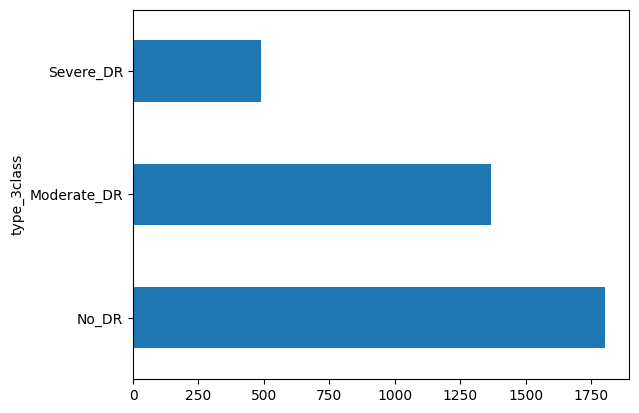

In [8]:
df['type_3class'].value_counts().plot(kind='barh')

In [9]:
# Split into stratified train, val, and test sets
train_intermediate, val = train_test_split(df, test_size = 0.15, stratify = df['type_3class'])
train, test = train_test_split(train_intermediate, test_size = 0.15 / (1 - 0.15), stratify = train_intermediate['type_3class'])

print(train['type_3class'].value_counts(), '\n')
print(test['type_3class'].value_counts(), '\n')
print(val['type_3class'].value_counts(), '\n')


type_3class
No_DR          1263
Moderate_DR     957
Severe_DR       342
Name: count, dtype: int64 

type_3class
No_DR          271
Moderate_DR    206
Severe_DR       73
Name: count, dtype: int64 

type_3class
No_DR          271
Moderate_DR    206
Severe_DR       73
Name: count, dtype: int64 



In [10]:
# Create working directories for train/val/test
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)

In [11]:
# Copy images to respective working directory
src_dir = '/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images'
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['type_3class']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['type_3class']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)
 
for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['type_3class']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)


In [12]:
#Setting up ImageDataGenerator for train/val/test 

train_path = 'train'
val_path = 'val'
test_path = 'test'

train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), class_mode='categorical', shuffle = True)
val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_path, target_size=(224,224), class_mode='categorical', shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), class_mode='categorical', shuffle = False)

Found 2562 images belonging to 3 classes.
Found 550 images belonging to 3 classes.
Found 550 images belonging to 3 classes.


In [13]:
# Building the model

model = tf.keras.Sequential([
    layers.Conv2D(8, (3,3), padding="valid", input_shape=(224,224,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(16, (3,3), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(32, (4,4), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
 
    layers.Flatten(),
    layers.Dense(32, activation = 'relu'),
    layers.Dropout(0.15),
    layers.Dense(3, activation = 'softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

history = model.fit(train_batches,
                    epochs=30,
                    validation_data=val_batches)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1725130626.701713     138 service.cc:145] XLA service 0x7c0df0010120 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725130626.701790     138 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 3/81 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.3941 - loss: 1.3610 

I0000 00:00:1725130632.332794     138 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 143ms/step - accuracy: 0.6400 - loss: 0.8860 - val_accuracy: 0.3745 - val_loss: 1.0927
Epoch 2/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - accuracy: 0.7547 - loss: 0.5963 - val_accuracy: 0.3745 - val_loss: 1.2888
Epoch 3/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - accuracy: 0.7935 - loss: 0.5309 - val_accuracy: 0.3764 - val_loss: 1.3014
Epoch 4/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - accuracy: 0.8045 - loss: 0.4996 - val_accuracy: 0.4073 - val_loss: 1.1900
Epoch 5/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - accuracy: 0.8206 - loss: 0.4579 - val_accuracy: 0.5491 - val_loss: 0.8947
Epoch 6/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - accuracy: 0.8199 - loss: 0.4527 - val_accuracy: 0.7327 - val_loss: 0.6307
Epoch 7/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.8392 - loss: 0.4155 - val_accuracy: 0.7909 - val_loss: 0.5300
Epoch 8/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - accuracy: 0.8461 - loss: 0.4054 - val_accuracy: 0.7873 - val_loss: 

In [14]:
model.save('eyenet_CNN.model.h5')

In [15]:
# VGG16 Model
vgg_model = tf.keras.Sequential([
    tf.keras.applications.VGG16(input_shape=(224,224,3), include_top=False, weights='imagenet'),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.15),
    layers.Dense(3, activation='softmax')
])

vgg_model.layers[0].trainable = False  # Freeze VGG16 layers

vgg_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

vgg_history = vgg_model.fit(train_batches, 
                            validation_data=val_batches, 
                            epochs=30)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 24s 167ms/step - accuracy: 0.5489 - loss: 0.9833 - val_accuracy: 0.7600 - val_loss: 0.6304
Epoch 2/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.7519 - loss: 0.6455 - val_accuracy: 0.7727 - val_loss: 0.5792
Epoch 3/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - accuracy: 0.7706 - loss: 0.5724 - val_accuracy: 0.7909 - val_loss: 0.5535
Epoch 4/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - accuracy: 0.7915 - loss: 0.5452 - val_accuracy: 0.8000 - val_loss: 0.5403
Epoch 5/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.8052 - loss: 0.5178 - val_accuracy: 0.8018 - val_loss: 0.5281
Epoch 6/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - accuracy: 0.7864 - loss: 0.5361 - val_accuracy: 0.8091 - val_loss: 0.5184
Epoch 7/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - accuracy: 0.8133 - loss: 0.5057 - val_accuracy: 0.8127 - val_loss: 0.5115
Epoch 8/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - accur

In [16]:
vgg_model.save('eyenet_vgg16.model.h5')

In [17]:
# ResNet50 Model
resnet_model = tf.keras.Sequential([
    tf.keras.applications.ResNet50(input_shape=(224,224,3), include_top=False, weights='imagenet'),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.15),
    layers.Dense(3, activation='softmax')
])

resnet_model.layers[0].trainable = False  # Freeze ResNet50 layers

resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

resnet_history = resnet_model.fit(train_batches, 
                                  validation_data=val_batches, 
                                  epochs=30)



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 31s 216ms/step - accuracy: 0.4849 - loss: 1.1050 - val_accuracy: 0.7418 - val_loss: 0.7933
Epoch 2/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - accuracy: 0.7056 - loss: 0.7733 - val_accuracy: 0.7491 - val_loss: 0.7103
Epoch 3/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - accuracy: 0.7532 - loss: 0.6955 - val_accuracy: 0.7491 - val_loss: 0.6752
Epoch 4/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - accuracy: 0.7474 - loss: 0.6626 - val_accuracy: 0.7509 - val_loss: 0.6571
Epoch 5/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - accuracy: 0.7534 - loss: 0.6564 - val_accuracy: 0.7600 - val_loss: 0.6453
Epoch 6/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - accuracy: 0.7330 - loss: 0.6585 - val_accuracy: 0.7455 - val_loss: 0.6378
Epoch 7/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.7474 - loss: 0.6289 - val_accuracy: 0.7636 - val_loss: 0.6365
Epoch 8/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - accur

In [18]:
resnet_model.save('eyenet_resnet50.model.h5')

In [22]:
# Evaluate Models
loss, acc = model.evaluate(test_batches, verbose=1)
print("CNN test Accuracy: ", acc)

loss, acc = vgg_model.evaluate(test_batches, verbose=1)
print("vgg16 test Accuracy: ", acc)

loss, acc = resnet_model.evaluate(test_batches, verbose=1)
print("resnet50 test Accuracy: ", acc)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.8889 - loss: 0.4200
CNN test Accuracy:  0.8309090733528137
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.9115 - loss: 0.3932
vgg16 test Accuracy:  0.8218181729316711
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.8864 - loss: 0.5144
resnet50 test Accuracy:  0.7927272915840149


In [29]:
# Diabetic Retinopathy Detection Section

import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt


def predict_class(path):
    img = cv2.imread(path)

    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    RGBImg = cv2.resize(RGBImg, (224, 224))
    plt.imshow(RGBImg)
    image = np.array(RGBImg) / 255.0
    new_model = tf.keras.models.load_model("eyenet_CNN.model.h5")
    predict = new_model.predict(np.array([image]))
    class_idx = np.argmax(predict, axis=1)[0]
    class_labels = ['No_DR', 'Moderate', 'Severe']
    print(class_labels[class_idx])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
Moderate


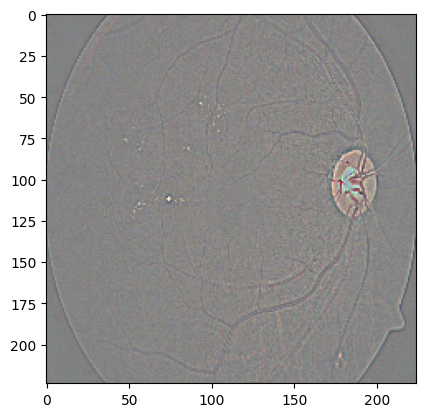

In [36]:
predict_class('/kaggle/working/test/Moderate_DR/663a923d5398.png')